# ANHA4 Inter-annual Runoff Estimations

In [9]:
import sys
sys.path.insert(0, '_libs/')

In [30]:
import glob
import scipy.io
import datetime
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from NEMO_tools import reporj_NEMOgrid
from dateutil.relativedelta import relativedelta
% matplotlib inline

# Spatial distribution

In [11]:
test_obj = nc.Dataset('_data/NEMO/ANHA4/ANHA4_runoff_monthly_combined_Dai_Trenberth_Bamber_y2014.nc')
rf2014 = test_obj.variables['runoff'][:]
nav_lon = test_obj.variables['nav_lon'][:]
nav_lat = test_obj.variables['nav_lat'][:]

In [4]:
lev = np.arange(1, 11, 1)

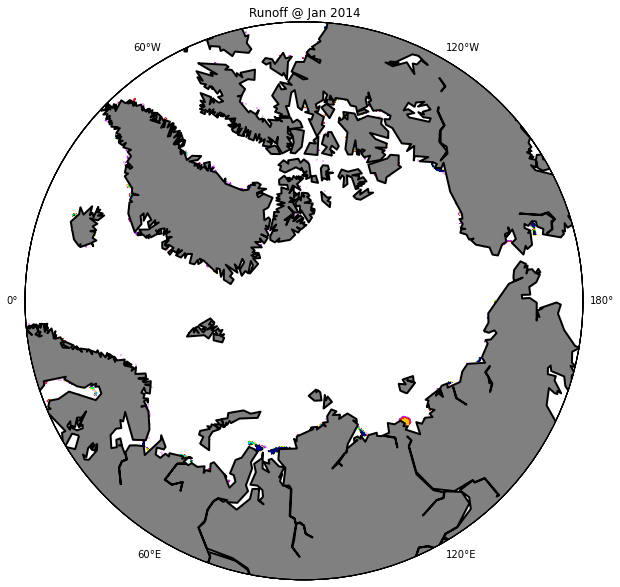

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

proj=Basemap(projection='npstere', resolution='c', boundinglat=60, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=2.0, linestyle='-', color='k')
x, y=proj(nav_lon, nav_lat)
CS = proj.contourf(x, y, rf2014[0, :, :]*1e4, lev, cmap=plt.cm.gist_ncar_r, extend='max')
ax.set_title('Runoff @ Jan 2014')

In [5]:
def zoomin_ortho_rf(nav_lon, nav_lat, rf, lev, ax, cmap=plt.cm.nipy_spectral_r, zoom_in_param=[70, -120, 0.125, 0.05]):
    center_lat = zoom_in_param[0]
    center_lon = zoom_in_param[1]
    coefx = zoom_in_param[2]; coefy = zoom_in_param[3]
    ref_map=Basemap(projection='ortho',\
                lat_0=center_lat, lon_0=center_lon, resolution=None)
    width=(ref_map.urcrnrx-ref_map.llcrnrx)*coefx  
    height=(ref_map.urcrnry-ref_map.llcrnry)*coefy 

    proj=Basemap(projection='ortho',\
            lat_0=center_lat, lon_0=center_lon, resolution='i',\
            llcrnrx=-0.5*width, llcrnry=-0.5*height, \
            urcrnrx=0.5*width, urcrnry=0.5*height, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 15), labels=[0, 0, 0, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.0, linestyle='-', color='k')
    x, y=proj(nav_lon, nav_lat)
    CS = proj.contourf(x, y, rf, lev, cmap=plt.cm.gist_ncar_r, extend='max')
    return CS

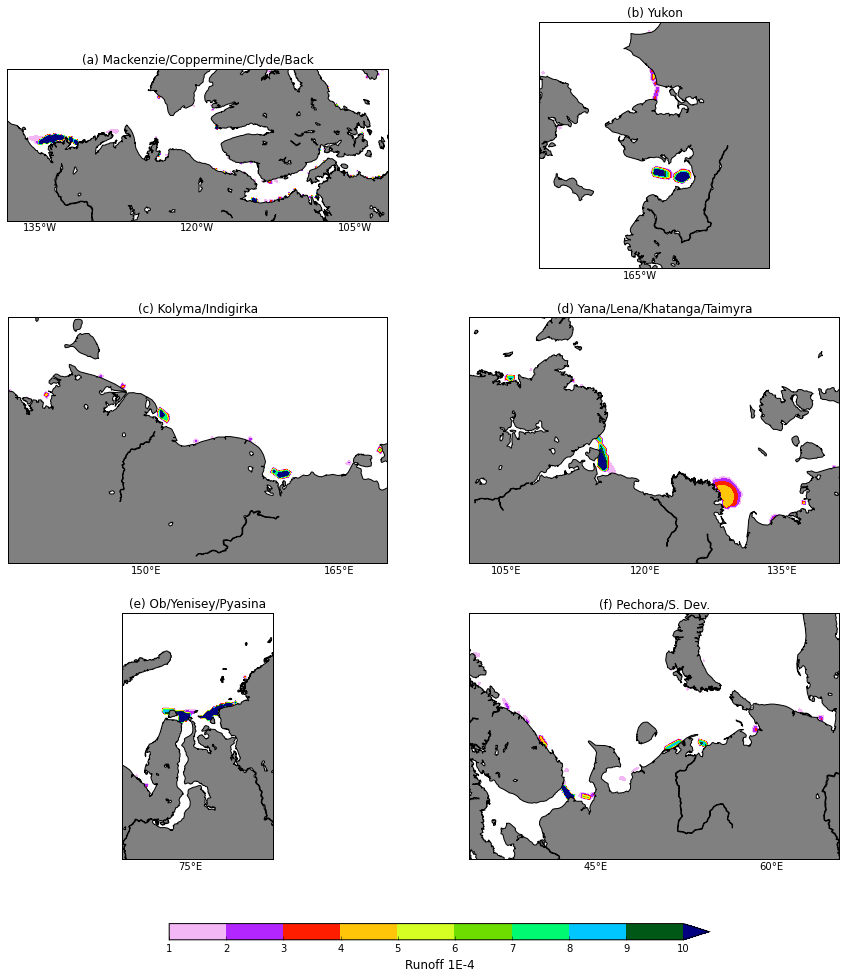

In [30]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=1, rowspan=1)
ax6 = plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)

CS = zoomin_ortho_rf(nav_lon, nav_lat, rf2014[0, :, :]*1e4, lev, ax=ax1, zoom_in_param=[70, -120, 0.125, 0.05])
ax1.set_title('(a) Mackenzie/Coppermine/Clyde/Back')
zoomin_ortho_rf(nav_lon, nav_lat, rf2014[0, :, :]*1e4, lev, ax=ax2, zoom_in_param=[65, -164, 0.07, 0.075])
ax2.set_title('(b) Yukon')
zoomin_ortho_rf(nav_lon, nav_lat, rf2014[0, :, :]*1e4, lev, ax=ax3, zoom_in_param=[71, 154, 0.1, 0.065])
ax3.set_title('(c) Kolyma/Indigirka')
zoomin_ortho_rf(nav_lon, nav_lat, rf2014[0, :, :]*1e4, lev, ax=ax4, zoom_in_param=[75, 121, 0.12, 0.08])
ax4.set_title('(d) Yana/Lena/Khatanga/Taimyra')
zoomin_ortho_rf(nav_lon, nav_lat, rf2014[0, :, :]*1e4, lev, ax=ax5, zoom_in_param=[72, 76, 0.08, 0.13])
ax5.set_title('(e) Ob/Yenisey/Pyasina')
zoomin_ortho_rf(nav_lon, nav_lat, rf2014[0, :, :]*1e4, lev, ax=ax6, zoom_in_param=[69, 50, 0.12, 0.08])
ax6.set_title('(f) Pechora/S. Dev.')

cax  = fig.add_axes([0.275, 0.05, 0.5, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Runoff 1E-4', fontsize=12)

# Get runoff on each river

In [12]:
ANHA4_MAT=scipy.io.loadmat('_data/Exchange/coord_ANHA4.mat')
ANHA4_lon=ANHA4_MAT['nav_lon']
ANHA4_lat=ANHA4_MAT['nav_lat']

In [13]:
MAT=scipy.io.loadmat('_data/Exchange/River_class_ORCA2.mat')
lon = MAT['lon_c']
lat = MAT['lat_c']
Class = MAT['River_class_c']

In [14]:
Class_interp = reporj_NEMOgrid(lon, lat, Class, ANHA4_lon, ANHA4_lat, method='nearest')
Class_range = reporj_NEMOgrid(lon, lat, Class, ANHA4_lon, ANHA4_lat, method='linear')
Class_interp[np.isnan(Class_range)] = np.nan

In [25]:
rf_name = glob.glob('_data/NEMO/ANHA4/*.nc')[1:]
NUM = len(rf_name)
MK = np.zeros(NUM*12)
for i in range(NUM):
    nc_obj = nc.Dataset(rf_name[i])
    temp_rf = nc_obj.variables['runoff'][:]
    temp_rf[temp_rf==0]=np.nan
    for j in range(12):
        temp_rf_m = temp_rf[j, :, :]
        MK[12*i+j] = np.nanmean(temp_rf_m[Class_interp.T==7])

In [31]:
date_list = []
base = datetime.datetime(1958, 1, 1)
date_list += [base + relativedelta(months=x) for x in range(0, NUM*12, 1)]

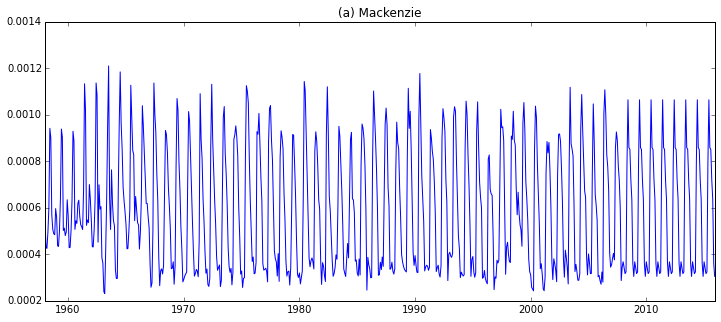

In [35]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(date_list, MK)
ax.set_title('(a) Mackenzie')